# **Import Library**

In [ ]:
!pip install scikit-image
!pip install tensorflow

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, os, sys
import itertools
import imageio
plt.style.use('default')

from __future__ import absolute_import, division, print_function, unicode_literals
from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from scipy import ndimage

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# **Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-4-200871013503>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("/content/drive/MyDrive/Jenis_Kulit/train/normal/Normal13_jpg.rf.65ff7cb28ff9a22044cce5f413e874dd.jpg")


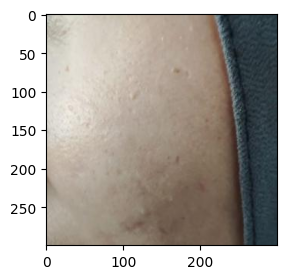

In [4]:
# Cek Gambar
image = imageio.imread("/content/drive/MyDrive/Jenis_Kulit/train/normal/Normal13_jpg.rf.65ff7cb28ff9a22044cce5f413e874dd.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

# **Image Data Generator**

In [5]:
img_height, img_width = 224, 224
batch_size = 32
base_dir = os.path.join('drive/MyDrive/Jenis_Kulit/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset ='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset ='validation')

Found 336 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [6]:
X_test = []
y_test = []
# Iterasi setiap folder dalam direktori utama
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    # Lewati jika bukan folder
    if not os.path.isdir(class_dir):
        continue
    # Iterasi setiap gambar dalam folder kelas
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        # Load dan praproses gambar
        img = tf.keras.preprocessing.image.load_img(file_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img_resized = tf.image.resize(img_array, (224, 224))
        X_test.append(img_resized)
        y_test.append(class_name)

In [7]:
# Ubah list menjadi array NumPy
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ambil satu batch pertama dari data training
for x_train_batch, y_train_batch in train_generator:
    break
print("Ukuran Train :", x_train_batch.shape, y_train_batch.shape)

# Ambil satu batch pertama dari data validasi
for x_val_batch, y_val_batch in val_generator:
    break
print("Ukuran Validasi:", x_val_batch.shape, y_val_batch.shape)

# Cetak shape dari data uji
print("Ukuran Test :", X_test.shape, y_test.shape)

Ukuran Train : (32, 224, 224, 3) (32, 3)
Ukuran Validasi: (32, 224, 224, 3) (32, 3)
Ukuran Test : (420, 224, 224, 3) (420,)


In [8]:
# Cetak indeks kelas yang dipetakan oleh generator
print(train_generator.class_indices)

# Simpan nama-nama kelas (label) ke dalam file teks
class_labels = sorted(train_generator.class_indices.keys())
label_text = '\n'.join(class_labels)

with open('labels.txt', 'w') as file:
    file.write(label_text)

{'dry': 0, 'normal': 1, 'oily': 2}


# **Modelling**

In [36]:
# Tentukan bentuk input gambar
input_shape = (224, 224, 3)

# Load model MobileNet tanpa fully-connected layer (top), dengan bobot dari ImageNet
base_model = tf.keras.applications.MobileNet(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# Nonaktifkan training untuk semua layer pada base model
base_model.trainable = False

# Tampilkan arsitektur model
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [37]:
# Bangun model Sequential dengan MobileNet sebagai base
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 32)       │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,523,907 (13.44 MB)

 Trainable params: 295,043 (1.13 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [38]:
# Definisikan Callback
class Early_Stopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")

        if train_acc is not None and val_acc is not None:
            if train_acc >= 0.95 and val_acc >= 0.85:
                print(f"\n Akurasi training dan validasi telah mencapai syarat pada epoch {epoch+1}, menghentikan training.")
                self.model.stop_training = True

In [39]:
# Training Model

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[Early_Stopping()]
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 668ms/step - accuracy: 0.4420 - loss: 2.5776 - val_accuracy: 0.6548 - val_loss: 0.8308
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.6999 - loss: 0.6289 - val_accuracy: 0.7619 - val_loss: 0.4073
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.7785 - loss: 0.4241 - val_accuracy: 0.8810 - val_loss: 0.3503
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.9378 - loss: 0.2789 - val_accuracy: 0.8929 - val_loss: 0.2783
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.9258 - loss: 0.2195 - val_accuracy: 0.8929 - val_loss: 0.2487
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9409 - loss: 0.1585
 Akurasi training dan validasi telah mencapai syarat pada epoch 6, menghentikan training.
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.9419 - loss: 0.1589 - val_accuracy: 0.9167 - val_loss: 0.2323


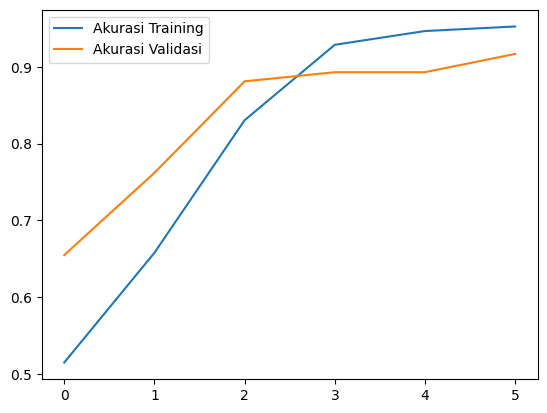

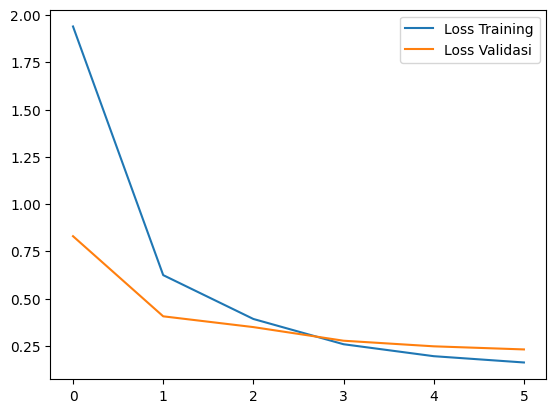

In [40]:
plt.plot(history.history["accuracy"], label="Akurasi Training")
plt.plot(history.history["val_accuracy"], label = "Akurasi Validasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Loss Training")
plt.plot(history.history["val_loss"], label="Loss Validasi")
plt.legend()
plt.show()

# **Evaluasi**

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step


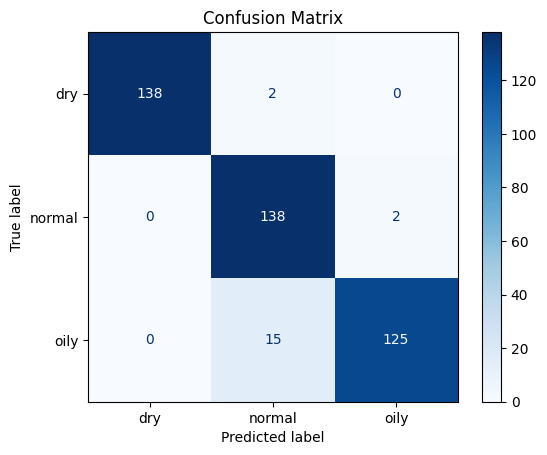

Hasil Klasifikasi:

              precision    recall  f1-score   support

         dry       1.00      0.99      0.99       140
      normal       0.89      0.99      0.94       140
        oily       0.98      0.89      0.94       140

    accuracy                           0.95       420
   macro avg       0.96      0.95      0.95       420
weighted avg       0.96      0.95      0.95       420



In [41]:
# Prediksi probabilitas
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Mapping label string ke indeks numerik
label_to_index = train_generator.class_indices
index_to_label = {v: k for k, v in label_to_index.items()}

# Konversi label string y_test ke label numerik
y_true = np.array([label_to_index[label] for label in y_test])

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=index_to_label.values())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Hasil Klasifikasi
hasil = classification_report(y_true, y_pred, target_names=index_to_label.values())
print("Hasil Klasifikasi:\n")
print(hasil)

# **Inferensi Model**

In [44]:
# Fungsi Prediksi Gambar
def predict_image(img_path, model, class_names, img_size=(224, 224)):
    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimensi

    # Prediksi
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_label = class_names[predicted_index]
    confidence = predictions[0][predicted_index]

    # Tampilkan hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_label} ({confidence:.2%})")
    plt.show()

    return predicted_label, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


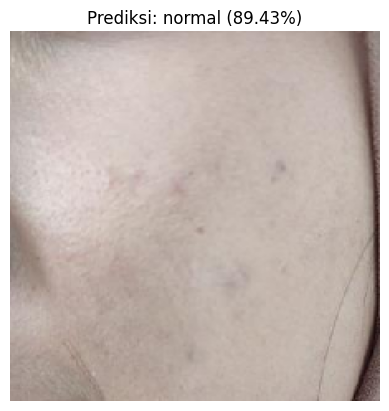

('normal', np.float32(0.89429283))

In [45]:
class_names = list(train_generator.class_indices.keys())
img_path = '/content/drive/MyDrive/Jenis_Kulit/test/normal/Normal76_jpg.rf.e8d85413b0172bb114c1f0681d72afd5.jpg'

predict_image(img_path, model, class_names)

# **Konversi Model**

In [52]:
model.save("model_saya.keras")

In [53]:
model.export("saved_model/model_saya")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/model_saya')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at 'saved_model/model_saya'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_278')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135397079404752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135397079406096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135397079410128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135397079410512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135397079411472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135397079411280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135397079409936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135397079412816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135397079412624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135397079402640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1353

In [56]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [57]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    saved_model/model_saya tfjs_model

2025-06-08 09:26:15.383162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749374775.403884   29508 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749374775.409786   29508 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-08 09:26:21.600109: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1749374781.600277   29508 gpu_device.cc:2022] Created device /job:localhost/replica:0/task